In [ ]:
# Property values by zip code (Zillow and Trulia) and business pattern data (US census) 

In [3]:
from random import randint
import pandas as pd
from pandas import DataFrame
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
import csv
from datetime import datetime   # one part of the main module

In [99]:
"""
    Zillow does not provide history data: can't use it
"""
# zwsid = 'X1-ZWz1ewzc1aj37v_65xu9'
# state = 'WA'
# city = 'Seattle'
# neighborhood = 'Ballard'

# #query_url = 'http://www.zillow.com/webservice/GetDemographics.htm?zws-id=%s&state=%s&city=%s&neighborhood=%s' % (zwsid,state,city,neighborhood)
# query_url = 'http://www.zillow.com/webservice/GetDeepComps.htm?zws-id=%s&zpid=48749425&count=5' % (zwsid) 
# r = requests.get(query_url)

In [ ]:
"""
    So we're going to use Trulia.
"""
trulia_api_key = ''
query_url = 'http://api.trulia.com/webservices.php?library=TruliaStats&function=getCityStats&city=New York&state=NY&startDate=2007-02-10&endDate=2009-02-07&apikey=%s' % (trulia_api_key)
r = requests.get(query_url)

## 1. Get zip code from wikipedia

In [20]:
""" GET SF ZIP CODES from http://www.city-data.com/zipmaps/San-Francisco-California.html    
"""
import itertools
sf_zip_codes = [94102, 94103, 94104, 94105, 94107, 94108, 94109, 94110, 94111, 94112, 94114, 94115, 94116, 94117, 94118, 94121, 94122, 94123, 94124, 94127, 94129, 94131, 94132, 94133, 94134, 94158]

## 2. Convert zip code to coordinates

In [364]:
""" Geopy has zip code converter! """
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode("78704")
print 'EXAMPLE:'
print(location.address)
print((location.latitude, location.longitude))

EXAMPLE:
Austin, Travis County, Texas, 78704, United States of America
(30.2447182141636, -97.7634808020997)


In [369]:
"""
    But something is wrong.
"""
location = geolocator.geocode(sf_zip_codes[0])
print 'EXAMPLE:'
print(location.address)
print((location.latitude, location.longitude))

EXAMPLE:
Mogiliovas, Klaipėda, Klaipėdos miesto savivaldybė, Klaipėdos apskritis, 94102, Lietuva
(55.6898967634684, 21.2091635778727)


In [4]:
"""
    So we're using Google Geocode API.
"""
GOOGLE_KEY = ''
query_url = 'https://maps.googleapis.com/maps/api/geocode/json?address=94102&key=%s' % (GOOGLE_KEY)
r = requests.get(query_url)

In [375]:
r.json()

{u'results': [{u'address_components': [{u'long_name': u'94102',
     u'short_name': u'94102',
     u'types': [u'postal_code']},
    {u'long_name': u'San Francisco',
     u'short_name': u'SF',
     u'types': [u'locality', u'political']},
    {u'long_name': u'San Francisco County',
     u'short_name': u'San Francisco County',
     u'types': [u'administrative_area_level_2', u'political']},
    {u'long_name': u'California',
     u'short_name': u'CA',
     u'types': [u'administrative_area_level_1', u'political']},
    {u'long_name': u'United States',
     u'short_name': u'US',
     u'types': [u'country', u'political']}],
   u'formatted_address': u'San Francisco, CA 94102, USA',
   u'geometry': {u'bounds': {u'northeast': {u'lat': 37.789226,
      u'lng': -122.4034491},
     u'southwest': {u'lat': 37.7694409, u'lng': -122.429849}},
    u'location': {u'lat': 37.7786871, u'lng': -122.4212424},
    u'location_type': u'APPROXIMATE',
    u'viewport': {u'northeast': {u'lat': 37.789226, u'lng': -122

In [399]:
"""
    Get coordinates.
"""
temp = r.json()
temp_ = temp['results'][0]['geometry']['location']
temp_

{u'lat': 37.7786871, u'lng': -122.4212424}

In [22]:
lats = []
lngs = []
for sf_zip_code in sf_zip_codes:
    query_url = 'https://maps.googleapis.com/maps/api/geocode/json?address=%s&key=%s' % (str(sf_zip_code),GOOGLE_KEY)
    r = requests.get(query_url)    
    temp = r.json()
    lat = temp['results'][0]['geometry']['location']['lat']
    lng = temp['results'][0]['geometry']['location']['lng']
    lats.append(lat)
    lngs.append(lng)

## 3. Sanity check: map visualization

In [24]:
import folium
m = folium.Map(location=[37.7786871, -122.4212424],zoom_start=13)
m.circle_marker(location=[37.7786871, -122.4212424],radius=100)
for i in range(len(sf_zip_codes)):
     m.circle_marker(location=[lats[i], lngs[i]], radius=500, #100 seems good enough for now
                    popup=str(sf_zip_codes[i]), line_color = "#980043",
                    fill_color="#980043", fill_opacity=.2)
m.create_map(path='sf_zip_code_map.html')

## 4. Get bussiness type and # of establishments per year from US census
Check [US census](http://www.census.gov/econ/cbp/) for the data. It can be downloaded as csv format.

In [51]:
# business type
df = pd.read_csv('zbp13detail.txt')
df.head()

,zip,naics,est,n1_4,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000
0,501,------,2,2,0,0,0,0,0,0,0,0
1,501,81----,2,2,0,0,0,0,0,0,0,0
2,501,813110,2,2,0,0,0,0,0,0,0,0
3,1001,------,439,199,68,75,52,28,14,2,0,1
4,1001,22----,2,1,0,0,1,0,0,0,0,0


In [37]:
sf_zip_codes = [94102, 94103, 94104, 94105, 94107, 94108, 94109, 94110, 94111, 94112, 94114, 94115, 94116, 94117, 94118, 94121, 94122, 94123, 94124, 94127, 94129, 94131, 94132, 94133, 94134, 94158]
oak_zip_codes = [94601, 94602, 94603, 94605, 94606, 94607, 94610, 94611, 94612, 94613, 94621]
bay_zip_codes = sf_zip_codes + oak_zip_codes

# save zipcode file
import csv
myfile = open('bay_zip_codes.csv', 'wb')
wr = csv.writer(myfile)
wr.writerow(bay_zip_codes)

In [48]:
# load zipcode file
with open('bay_zip_codes.csv', 'rb') as f:
    reader = csv.reader(f)
    bay_zip_codes = list(reader)[0]
# convert str list to int list
bay_zip_codes = map(int, bay_zip_codes)

In [50]:
df_sf_oak = df.loc[df['zip'].isin(bay_zip_codes)]

In [52]:
# save as a file
df_sf_oak.to_csv('ZCBT_sf_oak_2013.csv',encoding='utf-8',index=False)
# sf1.sort(columns='est',ascending=False)

In [55]:
df_sf_oak.tail()

,zip,naics,est,n1_4,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000
2972618,94621,813410,3,0,0,2,0,0,1,0,0,0
2972619,94621,813910,2,2,0,0,0,0,0,0,0,0
2972620,94621,813920,2,1,0,1,0,0,0,0,0,0
2972621,94621,813930,26,11,6,5,2,0,2,0,0,0
2972622,94621,99----,1,1,0,0,0,0,0,0,0,0


In [431]:
# let's compare to EPA
epa = b.loc[b['zip'] == 94303]
epa.sort(columns='est',ascending=False)

,zip,naics,est,n1_4,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000
2951410,94303,------,835,455,140,109,73,29,22,5,1,1
2951551,94303,54----,219,143,27,23,13,8,4,1,0,0
2951606,94303,62----,80,36,19,12,9,1,3,0,0,0
2951638,94303,81----,71,39,16,9,6,1,0,0,0,0
2951539,94303,53----,60,47,5,4,3,0,1,0,0,0
2951478,94303,44----,56,19,14,12,4,3,3,1,0,0
2951414,94303,23----,53,29,8,7,7,2,0,0,0,0
2951594,94303,61----,44,17,6,7,7,4,2,1,0,0
2951562,94303,541511,40,32,4,0,1,1,2,0,0,0
2951582,94303,56----,40,22,6,6,1,2,3,0,0,0


## 3. Collect property values per zip code over time

In [353]:
import trulia.stats as trustat
import trulia.location as truloc
zip_code_stats = trulia.stats.TruliaStats(TRULIA_KEY).get_zip_code_stats(zip_code='90025', start_date='2014-01-01', end_date='2014-01-31')

In [354]:
temp = zip_code_stats['listingStats']['listingStat']
df = DataFrame(temp)
df.head()

,listingPrice,weekEndingDate
0,"{u'subcategory': [{u'type': u'All Properties',...",2014-01-04
1,"{u'subcategory': [{u'type': u'All Properties',...",2014-01-04
2,"{u'subcategory': [{u'type': u'All Properties',...",2014-01-11
3,"{u'subcategory': [{u'type': u'All Properties',...",2014-01-18
4,"{u'subcategory': [{u'type': u'All Properties',...",2014-01-18


In [355]:
def func(x,key):
    k = x['subcategory'][0][key] # here I read key values 
    return pd.Series(k)

In [356]:
df['numProperties']=df['listingPrice'].apply((lambda x: func(x,'numberOfProperties')))
df['medPrice']=df['listingPrice'].apply((lambda x: func(x,'medianListingPrice')))
df['avrPrice']=df['listingPrice'].apply((lambda x: func(x,'averageListingPrice')))
df = df.drop('listingPrice',1)
df.head()

,weekEndingDate,numProperties,medPrice,avrPrice
0,2014-01-04,58,738667,1138490
1,2014-01-04,68,737000,1061787
2,2014-01-11,54,738643,1149556
3,2014-01-18,55,739333,1132056
4,2014-01-18,58,744500,1140457


### Neighborhood boundaries in SF

In [357]:
"""
    Get neighborhoods
"""
neighborhoods = trulia.location.LocationInfo(TRULIA_KEY).get_neighborhoods_in_city('San Francisco', 'CA')

In [358]:
neighborhoods

[OrderedDict([(u'id', u'1386'), (u'name', u'Alamo Square')]),
 OrderedDict([(u'id', u'1387'), (u'name', u'Anza Vista')]),
 OrderedDict([(u'id', u'1388'), (u'name', u'Ashbury Heights')]),
 OrderedDict([(u'id', u'1389'), (u'name', u'Balboa Terrace')]),
 OrderedDict([(u'id', u'1390'), (u'name', u'Bayview')]),
 OrderedDict([(u'id', u'1391'), (u'name', u'Bernal Heights')]),
 OrderedDict([(u'id', u'1392'), (u'name', u"Bernt's Knoll")]),
 OrderedDict([(u'id', u'1393'), (u'name', u'Buena Vista Park')]),
 OrderedDict([(u'id', u'1394'), (u'name', u'Castro')]),
 OrderedDict([(u'id', u'1395'), (u'name', u'Central Richmond')]),
 OrderedDict([(u'id', u'1396'), (u'name', u'Central Sunset')]),
 OrderedDict([(u'id', u'1397'), (u'name', u'Central Waterfront')]),
 OrderedDict([(u'id', u'1398'), (u'name', u'Chinatown')]),
 OrderedDict([(u'id', u'1399'), (u'name', u'Civic Center')]),
 OrderedDict([(u'id', u'1400'), (u'name', u'Cole Valley')]),
 OrderedDict([(u'id', u'1401'), (u'name', u'Cow Hollow')]),
 Or

In [359]:
""" Trulia does not provide coordinates."""
Alamo_Square = neighborhoods[0]
Alamo_Square

OrderedDict([(u'id', u'1386'), (u'name', u'Alamo Square')])

In [ ]:
neighborhood_stats = trustat.TruliaStats(TRULIA_KEY).get_neighborhood_stats(neighborhood_id=7183, start_date='2012-01-01', end_date='2012-06-30')

In [229]:
neighborhood_stats.keys()

[u'location', u'trafficStats', u'listingStats']


In [230]:
neighborhood_stats['listingStats'].keys()

[u'listingStat']

In [236]:
a = neighborhood_stats['listingStats']['listingStat']
b = DataFrame(a)
b.head()

,listingPrice,weekEndingDate
0,"{u'subcategory': [{u'type': u'All Properties',...",2012-01-07
1,"{u'subcategory': [{u'type': u'All Properties',...",2012-01-14
2,"{u'subcategory': [{u'type': u'All Properties',...",2012-01-21
3,"{u'subcategory': [{u'type': u'All Properties',...",2012-01-28
4,"{u'subcategory': [{u'type': u'All Properties',...",2012-02-04


In [221]:
# Let's focus on All properties
x = b['listingPrice'][0]
x['subcategory'][0]

OrderedDict([(u'type', u'All Properties'),
             (u'numberOfProperties', u'35'),
             (u'medianListingPrice', u'1745143'),
             (u'averageListingPrice', u'2072702')])

In [222]:
x['subcategory'][0]['type']

u'All Properties'

In [237]:
b['numProperties']=b['listingPrice'].apply((lambda x: func(x,'numberOfProperties')))
b['medPrice']=b['listingPrice'].apply((lambda x: func(x,'medianListingPrice')))
b['avrPrice']=b['listingPrice'].apply((lambda x: func(x,'averageListingPrice')))

In [238]:
b.drop('listingPrice',1)

,weekEndingDate,numProperties,medPrice,avrPrice
0,2012-01-07,2,784000,784000
1,2012-01-14,2,784143,784143
2,2012-01-21,2,784500,784500
3,2012-01-28,2,784500,784500
4,2012-02-04,2,779667,749444
5,2012-02-11,2,784500,784500
6,2012-02-11,3,770000,723000
7,2012-02-18,3,739786,712929
8,2012-02-25,2,699500,699500
9,2012-03-03,2,685286,685286


In [259]:
matplotlib.dates.date2num(a)

734509.0

In [262]:
date_list=[]
for date in b['weekEndingDate']:
    date_list.append(datetime.strptime(date,'%Y-%m-%d'))
#a = datetime.strptime(b['weekEndingDate'],'%Y-%m-%d')

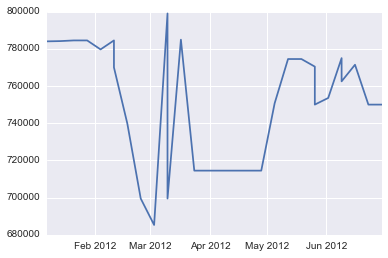

In [271]:
# plot time vs. value
dates = matplotlib.dates.date2num(date_list)

fig, ax = plt.subplots()
ax.plot_date(dates, b.medPrice,'-')